In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import urllib.request
import http.cookiejar
from skyfield.sgp4lib import EarthSatellite
import skyfield.api
import datetime

c = 299792458

In [2]:
frequency = 10706e6

In [3]:
def load_data(path, starting_day, frequency):
    with open(path) as f:
        data = [(s.split()[0], float(s.split()[5]), float(s.split()[7])) for s in f.readlines() if len(s.split()) >= 8]
    timestamps = np.array([np.datetime64(starting_day + 'T' + d[0]) for d in data])
    # correct rollover
    timestamps += np.concatenate(([0], np.cumsum(np.diff(np.array(timestamps)) < np.timedelta64(0)))) * np.timedelta64(3600*24)
    ppb = np.array([(d[1]-500+230)/frequency*1e9 for d in data])
    snr = np.array([d[2] for d in data])
    data = xr.Dataset({'ppb' : (['time'], ppb), 'snr' : (['time'], snr)}, coords = {'time':timestamps})
    #data.attrs['units'] = 'ppb'
    #data.name = 'Frequency offset'
    return data

In [4]:
x = load_data('3b8du/Eshail2 22122018.txt', '2018-12-22', frequency)
y = load_data('3b8du/Eshail2 23122018.txt', '2018-12-23', frequency)
z = load_data('3b8du/fmt Es\'Hail 2.txt', '2018-12-25', frequency)
data = x.combine_first(y).combine_first(z)

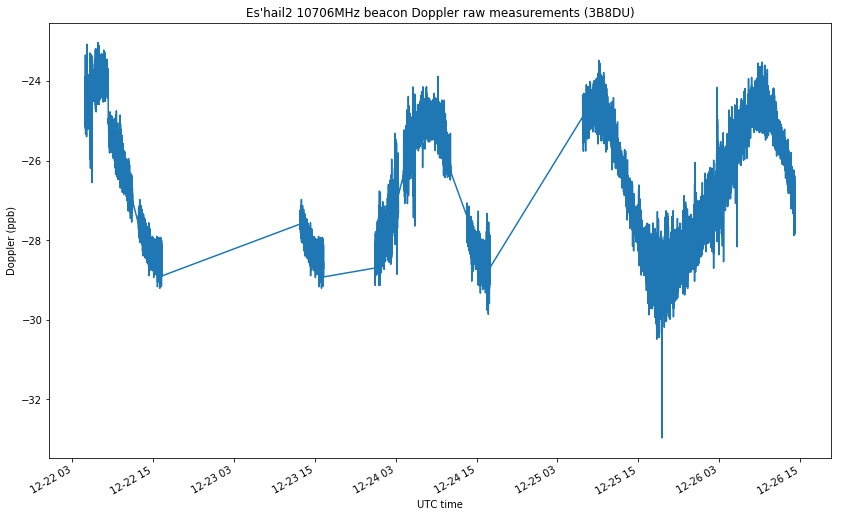

In [5]:
plt.figure(figsize = (14,8), facecolor='w')
data['ppb'].plot()
plt.title('Es\'hail2 10706MHz beacon Doppler raw measurements (3B8DU)')
plt.xlabel('UTC time')
plt.ylabel('Doppler (ppb)');

In [6]:
ppb_ea4gpz = xr.open_dataset('ppb.nc')

In [7]:
timesel = slice('2018-12-22T08:30', data.coords['time'][-1])

In [8]:
data_ea4gpz = ppb_ea4gpz['ppb'].sel(time = timesel).resample(time = '5min').mean()
correction = data_ea4gpz.mean()
data_3b8du = data['ppb'].sel(time = timesel).resample(time='5min').mean()

In [9]:
def opener_spacetrack(username, password):
    # todo: clean login info from ipynb file
    cj = http.cookiejar.CookieJar()
    opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cj))
    auth_url = 'https://www.space-track.org/ajaxauth/login/'
    auth_data = urllib.parse.urlencode({'identity' : username, 'password' : password}).encode('utf-8')
    auth_req = urllib.request.Request(auth_url, auth_data)
    r = opener.open(auth_req)
    return opener

def get_tles(opener):
    url = 'https://www.space-track.org/basicspacedata/query/class/tle/EPOCH/%3E2018-11-20/NORAD_CAT_ID/43700/orderby/EPOCH%20ASC/format/tle'
    r = opener.open(url)
    tle_lines = r.read().decode('ascii').split('\r\n')
    return [EarthSatellite(*x) for x in zip(tle_lines[::2], tle_lines[1::2])]

In [10]:
with open('../spacetrack_auth', 'r') as f:
    username, password = f.read().split('\n')[:2]
    opener = opener_spacetrack(username, password)

tles = get_tles(opener)

In [11]:
ts = skyfield.api.load.timescale()

In [12]:
midpoint = ts.utc(datetime.datetime(2018, 12, 24).replace(tzinfo = skyfield.api.utc))
best_tle = np.argmin(np.array([np.abs(t.epoch - midpoint) for t in tles]))
tle = tles[best_tle]

In [13]:
doppler_times = np.arange(data_ea4gpz.coords['time'].values[0], data_3b8du.coords['time'].values[-1], np.timedelta64(5, 'm'))
timestamps = (doppler_times - np.datetime64('1970-01-01T00:00:00'))/np.timedelta64(1, 's')
times = ts.utc([datetime.datetime.utcfromtimestamp(t).replace(tzinfo = skyfield.api.utc) for t in timestamps])

In [14]:
ea4gpz = skyfield.api.Topos(latitude = 40.595865, longitude = -3.699069, elevation_m = 800)
_3b8du = skyfield.api.Topos(latitude = -20.3125000, longitude = 57.5416667, elevation_m = 0)

In [15]:
rvs_ea4gpz = (tle - ea4gpz).at(times)
rvs_3b8du = (tle - _3b8du).at(times)
doppler_data = -np.diff(rvs_ea4gpz.distance().km)/300*1e12/c
doppler_ea4gpz = xr.DataArray(doppler_data,\
                           coords = {'time' : doppler_times[:-1]},\
                           dims=('time'))
doppler_data = -np.diff(rvs_3b8du.distance().km)/300*1e12/c
doppler_3b8du = xr.DataArray(doppler_data,\
                           coords = {'time' : doppler_times[:-1]},\
                           dims=('time'))

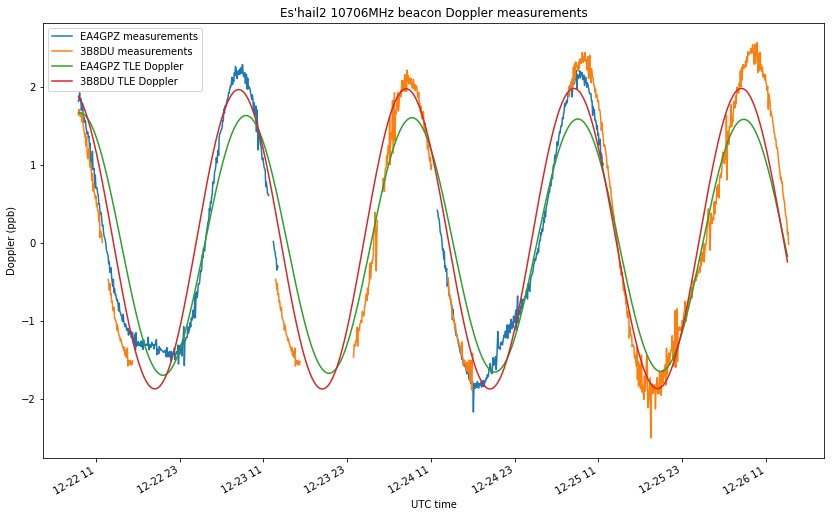

In [16]:
plt.figure(figsize = (14,8), facecolor='w')
(data_ea4gpz-correction).plot()
(data_3b8du-correction).plot()
doppler_ea4gpz.plot()
doppler_3b8du.plot()
plt.legend(['EA4GPZ measurements', '3B8DU measurements', 'EA4GPZ TLE Doppler', '3B8DU TLE Doppler'])
plt.title('Es\'hail2 10706MHz beacon Doppler measurements')
plt.xlabel('UTC time')
plt.ylabel('Doppler (ppb)');

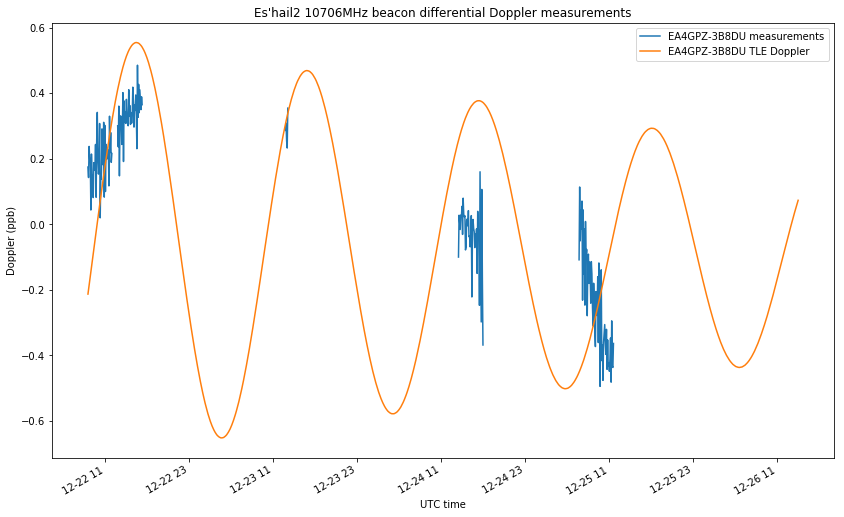

In [17]:
plt.figure(figsize = (14,8), facecolor='w')
(data_ea4gpz-data_3b8du).plot()
(doppler_ea4gpz-doppler_3b8du).plot()
plt.legend(['EA4GPZ-3B8DU measurements', 'EA4GPZ-3B8DU TLE Doppler'])
plt.title('Es\'hail2 10706MHz beacon differential Doppler measurements')
plt.xlabel('UTC time')
plt.ylabel('Doppler (ppb)');

In [18]:
subpoints = tle.at(times).subpoint()
longitude = subpoints.longitude.degrees
latitude = subpoints.latitude.degrees
elevation = subpoints.elevation.km

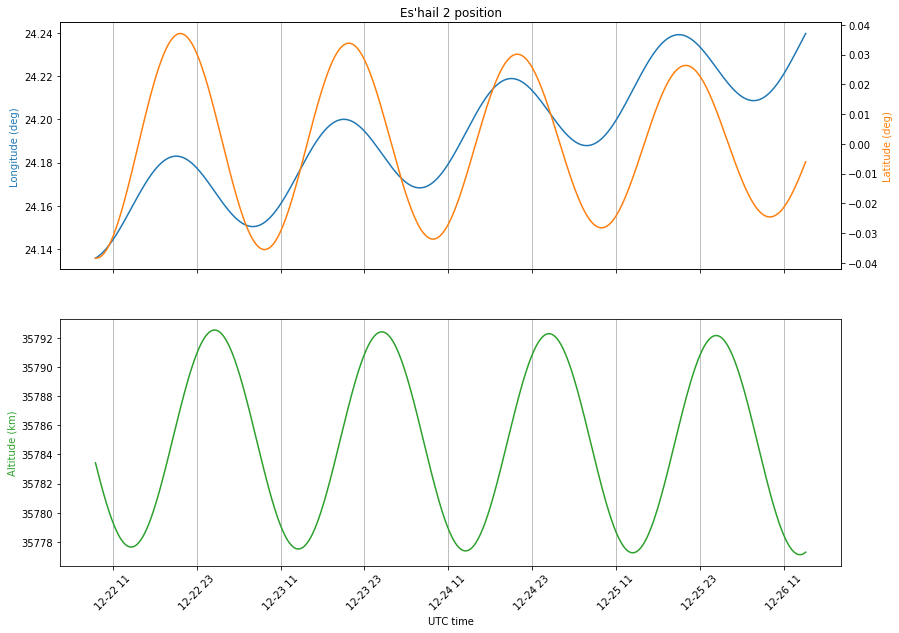

In [19]:
fig, axs = plt.subplots(2, figsize = (14, 10), facecolor = 'w')
ax1 = axs[0]
ax2 = ax1.twinx()
ax3 = axs[1]
ax1.plot(doppler_times, longitude, color = 'C0')
ax2.plot(doppler_times, latitude, color = 'C1')
ax3.plot(doppler_times, elevation, color = 'C2')
ax1.set_ylabel('Longitude (deg)', color = 'C0')
ax2.set_ylabel('Latitude (deg)', color = 'C1')
ax3.set_ylabel('Altitude (km)', color = 'C2')
ax1.set_title('Es\'hail 2 position')
ax1.xaxis.set_major_formatter(mdates.DateFormatter(''))
ax1.grid(axis = 'x')
ax3.grid(axis = 'x')
ax3.tick_params('x', rotation = 45)
ax3.set_xlabel('UTC time');

In [20]:
x_ea4gpz = ea4gpz.at(times[0]).position.km
x_3b8du = _3b8du.at(times[0]).position.km
y = tle.at(times[0]).position.km
altitude_projection_ea4gpz = np.sum((y-x_ea4gpz) * y)/(np.sqrt(np.sum((y-x_ea4gpz)**2))*np.sqrt(np.sum(y**2)))
altitude_projection_3b8du = np.sum((y-x_3b8du) * y)/(np.sqrt(np.sum((y-x_3b8du)**2))*np.sqrt(np.sum(y**2)))
latitude_projection_ea4gpz = (y-x_ea4gpz)[2]/np.sqrt(np.sum((y-x_ea4gpz)**2))
latitude_projection_3b8du = (y-x_3b8du)[2]/np.sqrt(np.sum((y-x_3b8du)**2))
z = np.array([-y[1], y[0], 0])
longitude_projection_ea4gpz = np.sum((y-x_ea4gpz) * z)/(np.sqrt(np.sum((y-x_ea4gpz)**2))*np.sqrt(np.sum(z**2)))
longitude_projection_3b8du = np.sum((y-x_3b8du) * z)/(np.sqrt(np.sum((y-x_3b8du)**2))*np.sqrt(np.sum(z**2)))
geo_height = np.sqrt(np.sum(y**2))
print('EA4GPZ sensitivity:', altitude_projection_ea4gpz, latitude_projection_ea4gpz, longitude_projection_ea4gpz)
print('3B8DU sensitivity:', altitude_projection_3b8du, latitude_projection_3b8du, longitude_projection_3b8du)
print('EA4GPZ-3B8DU sensitivity:', altitude_projection_ea4gpz-altitude_projection_3b8du, latitude_projection_ea4gpz-latitude_projection_3b8du, longitude_projection_ea4gpz-longitude_projection_3b8du)

EA4GPZ sensitivity: 0.9923503623740006 -0.10820374478548889 0.05916442128805995
3B8DU sensitivity: 0.9943716752976061 0.05906967632920649 -0.08805320824338027
EA4GPZ-3B8DU sensitivity: -0.0020213129236054117 -0.16727342111469537 0.14721762953144021


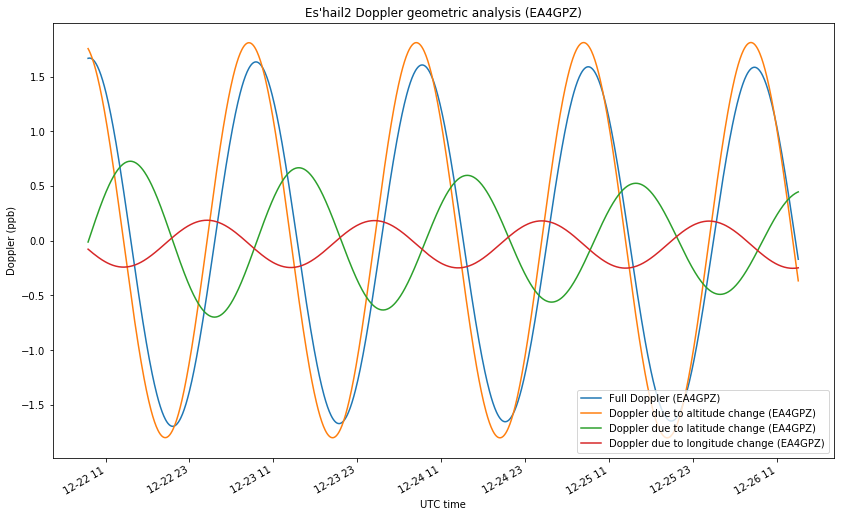

In [21]:
plt.figure(figsize = (14,8), facecolor='w')
doppler_ea4gpz.plot()
altitude_doppler = -altitude_projection_ea4gpz * np.diff(elevation)/300*1e12/c
latitude_doppler = -latitude_projection_ea4gpz * np.diff(np.deg2rad(latitude) * geo_height)/300*1e12/c
longitude_doppler = -longitude_projection_ea4gpz * np.diff(np.deg2rad(longitude) * geo_height)/300*1e12/c
plt.plot(doppler_times[:-1], altitude_doppler)
plt.plot(doppler_times[:-1], latitude_doppler)
plt.plot(doppler_times[:-1], longitude_doppler)
plt.legend(['Full Doppler (EA4GPZ)', 'Doppler due to altitude change (EA4GPZ)', 'Doppler due to latitude change (EA4GPZ)',
           'Doppler due to longitude change (EA4GPZ)'])
plt.title('Es\'hail2 Doppler geometric analysis (EA4GPZ)')
plt.xlabel('UTC time')
plt.ylabel('Doppler (ppb)');

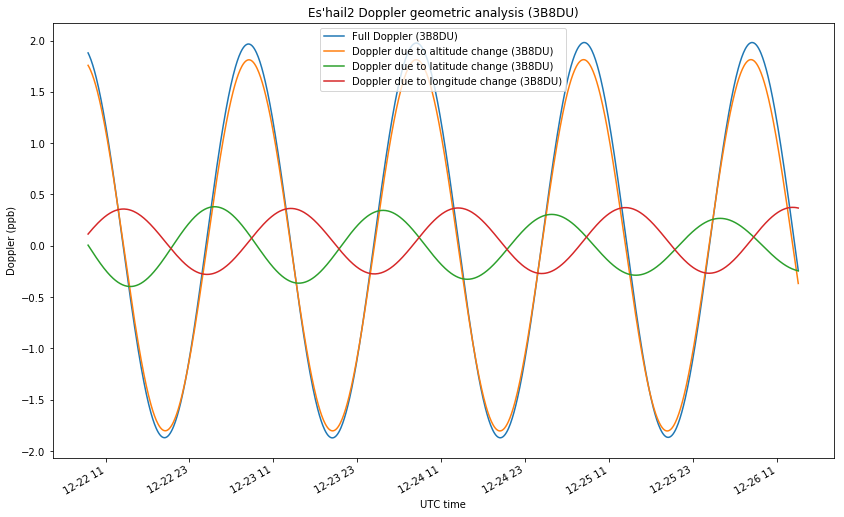

In [22]:
plt.figure(figsize = (14,8), facecolor='w')
doppler_3b8du.plot()
altitude_doppler = -altitude_projection_3b8du * np.diff(elevation)/300*1e12/c
latitude_doppler = -latitude_projection_3b8du * np.diff(np.deg2rad(latitude) * geo_height)/300*1e12/c
longitude_doppler = -longitude_projection_3b8du * np.diff(np.deg2rad(longitude) * geo_height)/300*1e12/c
plt.plot(doppler_times[:-1], altitude_doppler)
plt.plot(doppler_times[:-1], latitude_doppler)
plt.plot(doppler_times[:-1], longitude_doppler)
plt.legend(['Full Doppler (3B8DU)', 'Doppler due to altitude change (3B8DU)', 'Doppler due to latitude change (3B8DU)',
           'Doppler due to longitude change (3B8DU)'])
plt.title('Es\'hail2 Doppler geometric analysis (3B8DU)')
plt.xlabel('UTC time')
plt.ylabel('Doppler (ppb)');

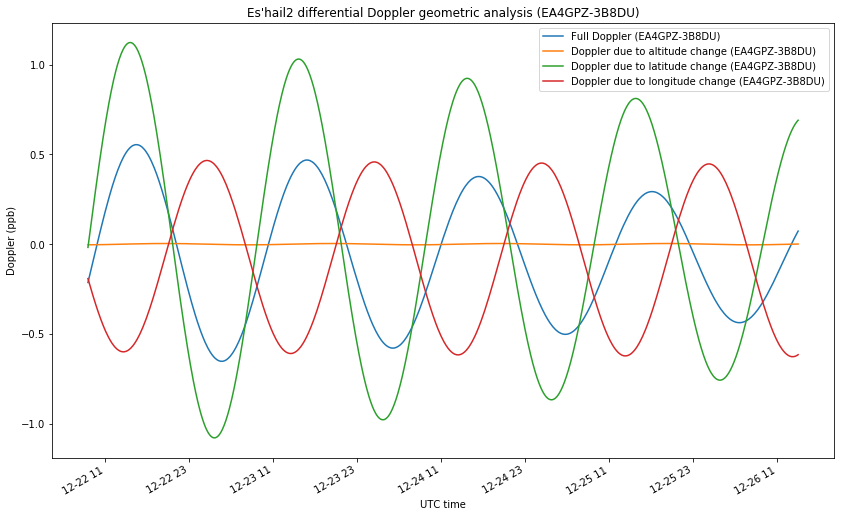

In [23]:
plt.figure(figsize = (14,8), facecolor='w')
(doppler_ea4gpz-doppler_3b8du).plot()
altitude_doppler = -(altitude_projection_ea4gpz-altitude_projection_3b8du) * np.diff(elevation)/300*1e12/c
latitude_doppler = -(latitude_projection_ea4gpz-latitude_projection_3b8du) * np.diff(np.deg2rad(latitude) * geo_height)/300*1e12/c
longitude_doppler = -(longitude_projection_ea4gpz-longitude_projection_3b8du) * np.diff(np.deg2rad(longitude) * geo_height)/300*1e12/c
plt.plot(doppler_times[:-1], altitude_doppler)
plt.plot(doppler_times[:-1], latitude_doppler)
plt.plot(doppler_times[:-1], longitude_doppler)
#plt.plot(doppler_times[:-1], altitude_doppler  + latitude_doppler + longitude_doppler)
plt.legend(['Full Doppler (EA4GPZ-3B8DU)', 'Doppler due to altitude change (EA4GPZ-3B8DU)', 'Doppler due to latitude change (EA4GPZ-3B8DU)',
           'Doppler due to longitude change (EA4GPZ-3B8DU)'])
plt.title('Es\'hail2 differential Doppler geometric analysis (EA4GPZ-3B8DU)')
plt.xlabel('UTC time')
plt.ylabel('Doppler (ppb)');

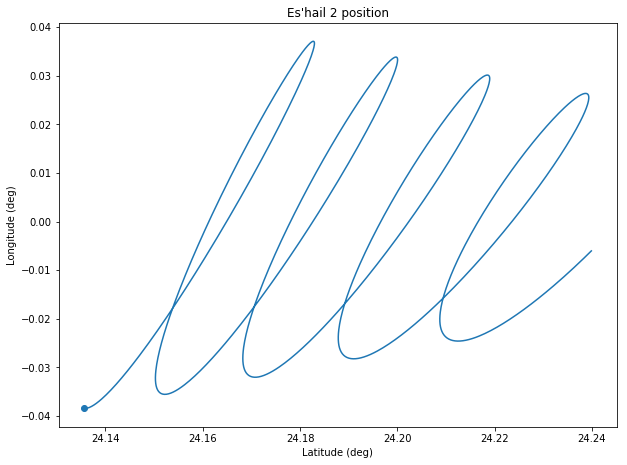

In [24]:
plt.figure(figsize = (10,10), facecolor='w')
plt.plot(longitude, latitude)
plt.plot(longitude[0], latitude[0], 'o', color = 'C0')
plt.gca().set_aspect(1.0)
plt.title('Es\'hail 2 position')
plt.xlabel('Latitude (deg)')
plt.ylabel('Longitude (deg)');